## Import Libraries

In [43]:
import pandas as pd
import numpy as np
import os
import random

# --- REPRODUCIBILITY SETUP ---
# We lock the seeds so every run produces the exact same result.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"Random Seed set to: {SEED}")

# --- DATA LOADING ---
# Updated paths for local execution (relative to notebook location)
# For Jupyter notebooks, use getcwd() to get the current working directory
notebook_dir = os.getcwd()
file_path_excel = os.path.join(notebook_dir, 'Dass21 Dataset.xlsx')
file_path_csv = os.path.join(notebook_dir, 'Dass21_Dataset_Converted.csv')

# Check if file exists to avoid errors
if os.path.exists(file_path_excel):
    print("Loading Excel file...")
    # Load the Excel file
    df = pd.read_excel(file_path_excel)

    # Save as CSV for future use (checkpoint)
    df.to_csv(file_path_csv, index=False)
    print(f"Converted and saved to: {file_path_csv}")

    # Display basic info
    print("\n--- Dataset Info ---")
    print(df.info())
    print("\n--- First 5 Rows ---")
    display(df.head())

elif os.path.exists(file_path_csv):
    print(f"Excel file not found. Loading from CSV: {file_path_csv}")
    df = pd.read_csv(file_path_csv)
    
    # Display basic info
    print("\n--- Dataset Info ---")
    print(df.info())
    print("\n--- First 5 Rows ---")
    display(df.head())
    
else:
    print(f"Error: Neither Excel file ({file_path_excel}) nor CSV file ({file_path_csv}) found. Please check the paths.")

Random Seed set to: 42
Error: Neither Excel file (c:\Users\User\Downloads\DASS21-main\Dass21 Dataset.xlsx) nor CSV file (c:\Users\User\Downloads\DASS21-main\Dass21_Dataset_Converted.csv) found. Please check the paths.


## Load Dataset

In [44]:
df = pd.read_excel('DASS 21 Dataset.xlsx')

## Data Preprocessing

In [45]:
# --- STEP 1: RENAME COLUMNS ---
# We use index-based renaming to avoid errors with spaces/typos in the original headers
new_column_names = ['Gender', 'Age'] + [f'Q{i}' for i in range(1, 22)]
df.columns = new_column_names

print("Columns renamed to standard format (Gender, Age, Q1...Q21).")

# --- STEP 2: STANDARDIZE CATEGORICAL DATA ---
# Clean Gender column: Remove spaces, make title case (e.g., " male " -> "Male")
df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
print(f"Unique Gender values found: {df['Gender'].unique()}")

# --- STEP 3: DATA CLEANING ---
initial_count = len(df)

# A. Remove Duplicate Rows
df = df.drop_duplicates()
duplicates_removed = initial_count - len(df)

# B. Remove "Straight-Liners" (Invalid Variance)
# Calculate standard deviation across Q1-Q21 for each student
question_cols = [f'Q{i}' for i in range(1, 22)]
row_std = df[question_cols].std(axis=1)
row_mean = df[question_cols].mean(axis=1)

# Logic: Drop if Standard Deviation is 0 AND Mean is not 0
# (We keep Mean=0 because it's valid to have no symptoms)
mask_invalid = (row_std == 0) & (row_mean > 0)
df_clean = df[~mask_invalid].copy()

straight_liners_removed = mask_invalid.sum()

# --- STEP 4: FINAL STATUS REPORT ---
print("\n--- Cleaning Report ---")
print(f"Original Rows: {initial_count}")
print(f"Duplicates Dropped: {duplicates_removed}")
print(f"Straight-Liners Dropped: {straight_liners_removed} (Response bias)")
print(f"Final Clean Rows: {len(df_clean)}")

# Update the main dataframe
df = df_clean

# Show the first few rows of the clean, renamed dataframe
display(df.head())

Columns renamed to standard format (Gender, Age, Q1...Q21).
Unique Gender values found: <StringArray>
['Male', 'Female']
Length: 2, dtype: str

--- Cleaning Report ---
Original Rows: 1641
Duplicates Dropped: 563
Straight-Liners Dropped: 3 (Response bias)
Final Clean Rows: 1075


,Gender,Age,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21
0,Male,24,2,2,2,0,3,2,0,3,...,1,3,2,2,3,2,1,3,1,1
1,Female,24,0,2,0,1,2,0,0,0,...,0,0,0,0,2,2,1,3,0,1
2,Male,25,3,3,3,2,3,2,3,3,...,3,1,2,3,2,3,3,2,3,2
3,Male,25,2,3,3,3,3,3,3,3,...,3,3,3,3,2,3,3,3,3,3
4,Male,23,1,3,0,1,1,1,1,1,...,1,1,1,0,2,0,1,0,1,0


## Scoring and Severity Analysis

In [46]:
# --- STEP 1: DEFINE SCALES ---
# Standard DASS-21 mapping
depression_cols = ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']
anxiety_cols    = ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']
stress_cols     = ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']

# --- STEP 2: CALCULATE SCORES ---
# We sum the answers (0-3) and multiply by 2 as per DASS-21 protocol
df['Depression_Score'] = df[depression_cols].sum(axis=1) * 2
df['Anxiety_Score']    = df[anxiety_cols].sum(axis=1) * 2
df['Stress_Score']     = df[stress_cols].sum(axis=1) * 2

# --- STEP 3: DEFINE SEVERITY CATEGORIES ---
# Official DASS-42 Cut-off points (after x2 multiplication)
def get_depression_label(score):
    if score <= 9: return 'Normal'
    elif score <= 13: return 'Mild'
    elif score <= 20: return 'Moderate'
    elif score <= 27: return 'Severe'
    else: return 'Extremely Severe'

def get_anxiety_label(score):
    if score <= 7: return 'Normal'
    elif score <= 9: return 'Mild'
    elif score <= 14: return 'Moderate'
    elif score <= 19: return 'Severe'
    else: return 'Extremely Severe'

def get_stress_label(score):
    if score <= 14: return 'Normal'
    elif score <= 18: return 'Mild'
    elif score <= 25: return 'Moderate'
    elif score <= 33: return 'Severe'
    else: return 'Extremely Severe'

# Apply the labeling functions
df['Depression_Level'] = df['Depression_Score'].apply(get_depression_label)
df['Anxiety_Level']    = df['Anxiety_Score'].apply(get_anxiety_label)
df['Stress_Level']     = df['Stress_Score'].apply(get_stress_label)

# --- STEP 4: CLASS DISTRIBUTION CHECK ---
# We need to know if our dataset is imbalanced (e.g., if everyone is "Normal")
print("--- Class Distribution (Depression) ---")
print(df['Depression_Level'].value_counts())
print("\n--- Class Distribution (Anxiety) ---")
print(df['Anxiety_Level'].value_counts())
print("\n--- Class Distribution (Stress) ---")
print(df['Stress_Level'].value_counts())

# Show the new columns
display(df[['Depression_Score', 'Depression_Level', 'Anxiety_Score', 'Anxiety_Level', 'Stress_Score', 'Stress_Level']].head())

--- Class Distribution (Depression) ---
Depression_Level
Moderate            403
Severe              228
Mild                181
Extremely Severe    138
Normal              125
Name: count, dtype: int64

--- Class Distribution (Anxiety) ---
Anxiety_Level
Extremely Severe    509
Moderate            246
Severe              237
Normal               43
Mild                 40
Name: count, dtype: int64

--- Class Distribution (Stress) ---
Stress_Level
Normal              342
Moderate            301
Mild                245
Severe              165
Extremely Severe     22
Name: count, dtype: int64


,Depression_Score,Depression_Level,Anxiety_Score,Anxiety_Level,Stress_Score,Stress_Level
0,34,Extremely Severe,18,Severe,26,Severe
1,14,Moderate,12,Moderate,2,Normal
2,34,Extremely Severe,38,Extremely Severe,36,Extremely Severe
3,40,Extremely Severe,42,Extremely Severe,40,Extremely Severe
4,10,Mild,12,Moderate,14,Normal


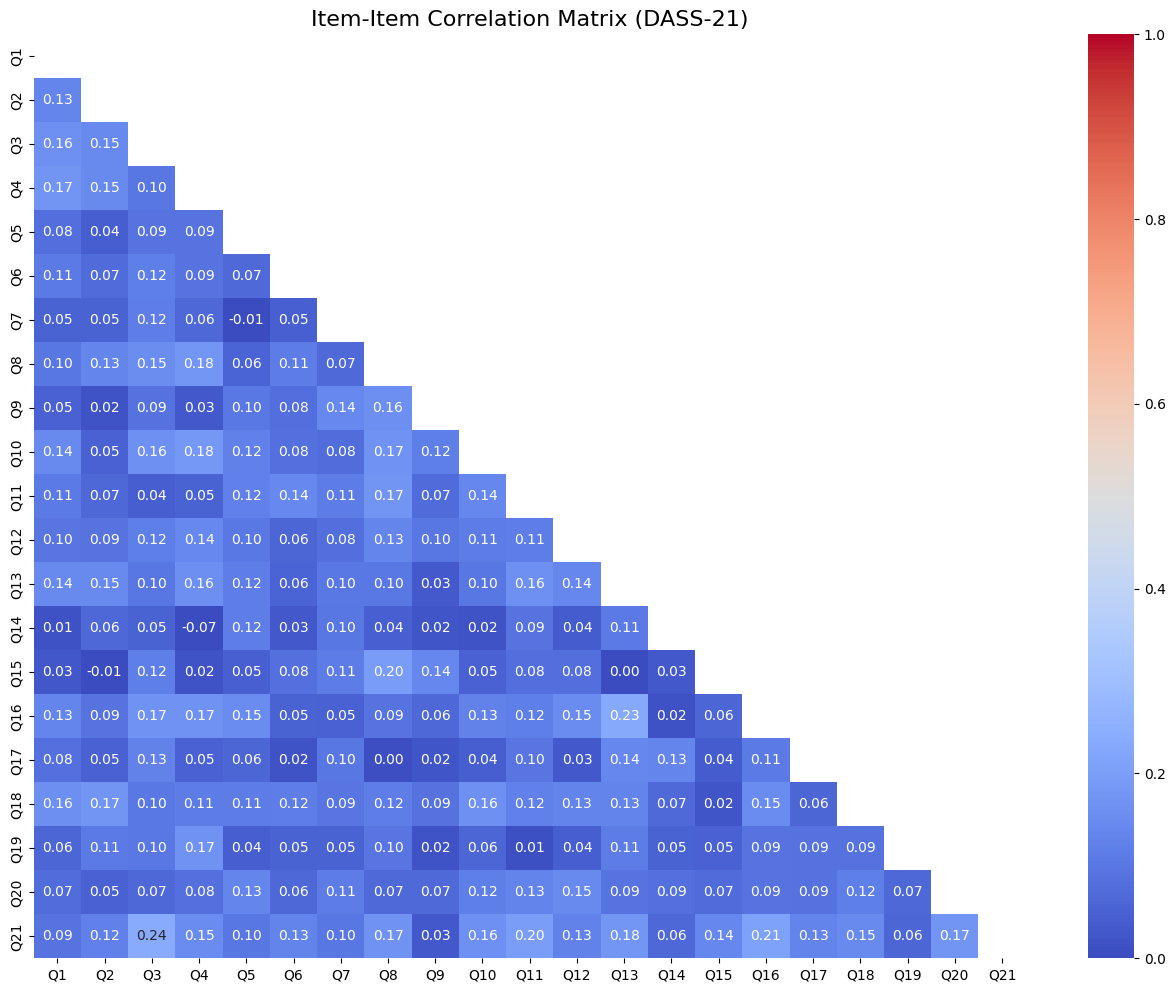

In [47]:
# --- STEP 1: INSTALL STATS LIBRARY ---
!pip install -q pingouin

import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# We define the subsets again for clarity
d_items = df[['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']]
a_items = df[['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']]
s_items = df[['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']]

# --- STEP 2: CORRELATION HEATMAP ---
# We visualize how the 21 questions relate to each other
plt.figure(figsize=(16, 12))
correlation_matrix = df[[f'Q{i}' for i in range(1, 22)]].corr()

# Create a mask to hide the upper triangle (for cleaner look)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1)
plt.title('Item-Item Correlation Matrix (DASS-21)', fontsize=16)
plt.show()

In [48]:
def optimize_scale(df, scale_name, items):
    current_items = items.copy()
    best_alpha = -1.0

    print(f"\n--- Optimizing {scale_name} Scale ---")
    print(f"Starting items: {current_items}")

    while len(current_items) > 3: # Keep at least 3 questions per scale
        # Calculate current alpha
        alpha = pg.cronbach_alpha(data=df[current_items])[0]
        print(f"Current Alpha ({len(current_items)} items): {alpha:.4f}")

        # If we hit our target, stop (optional, but let's try to max it out)
        if alpha > 0.75:
            print("Target Alpha reached!")
            break

        # identifying the "worst" item
        # We calculate alpha for every possible subset with 1 item removed
        candidates = {}
        for item in current_items:
            subset = [x for x in current_items if x != item]
            sub_alpha = pg.cronbach_alpha(data=df[subset])[0]
            candidates[item] = sub_alpha

        # Find which removal gives the HIGHEST alpha
        worst_item = max(candidates, key=candidates.get)
        new_best_alpha = candidates[worst_item]

        # If removing the item IMPROVES alpha, do it.
        # If removing it hurts alpha (drops it), then we have reached the peak.
        if new_best_alpha > alpha:
            print(f"  -> Removing {worst_item} improves Alpha to {new_best_alpha:.4f}")
            current_items.remove(worst_item)
            best_alpha = new_best_alpha
        else:
            print("  -> No further improvement possible.")
            break

    return current_items, alpha

# --- RUN OPTIMIZATION ---
d_items = ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']
a_items = ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']
s_items = ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']

final_d_items, final_alpha_d = optimize_scale(df, "Depression", d_items)
final_a_items, final_alpha_a = optimize_scale(df, "Anxiety", a_items)
final_s_items, final_alpha_s = optimize_scale(df, "Stress", s_items)

print("\n\n=== FINAL OPTIMIZED SCALES ===")
print(f"Depression: {final_d_items} (Alpha: {final_alpha_d:.3f})")
print(f"Anxiety   : {final_a_items} (Alpha: {final_alpha_a:.3f})")
print(f"Stress    : {final_s_items} (Alpha: {final_alpha_s:.3f})")

# --- UPDATE DATAFRAME WITH NEW SCORES ---
# We use ONLY the reliable items for the Machine Learning Phase
df['Depression_Score_Opt'] = df[final_d_items].sum(axis=1)
df['Anxiety_Score_Opt']    = df[final_a_items].sum(axis=1)
df['Stress_Score_Opt']     = df[final_s_items].sum(axis=1)

# Check correlations of the NEW scores
print("\n--- Correlation of Optimized Scores ---")
print(df[['Depression_Score_Opt', 'Anxiety_Score_Opt', 'Stress_Score_Opt']].corr())


--- Optimizing Depression Scale ---
Starting items: ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21']
Current Alpha (7 items): 0.5237
  -> No further improvement possible.

--- Optimizing Anxiety Scale ---
Starting items: ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20']
Current Alpha (7 items): 0.3594
  -> No further improvement possible.

--- Optimizing Stress Scale ---
Starting items: ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q14', 'Q18']
Current Alpha (7 items): 0.4368
  -> Removing Q14 improves Alpha to 0.4479
Current Alpha (6 items): 0.4479
  -> No further improvement possible.


=== FINAL OPTIMIZED SCALES ===
Depression: ['Q3', 'Q5', 'Q10', 'Q13', 'Q16', 'Q17', 'Q21'] (Alpha: 0.524)
Anxiety   : ['Q2', 'Q4', 'Q7', 'Q9', 'Q15', 'Q19', 'Q20'] (Alpha: 0.359)
Stress    : ['Q1', 'Q6', 'Q8', 'Q11', 'Q12', 'Q18'] (Alpha: 0.448)

--- Correlation of Optimized Scores ---
                      Depression_Score_Opt  Anxiety_Score_Opt  \
Depression_Score_Opt              1.000000           0.379528   
Anx

Explained Variance by 2 Components: 20.47%


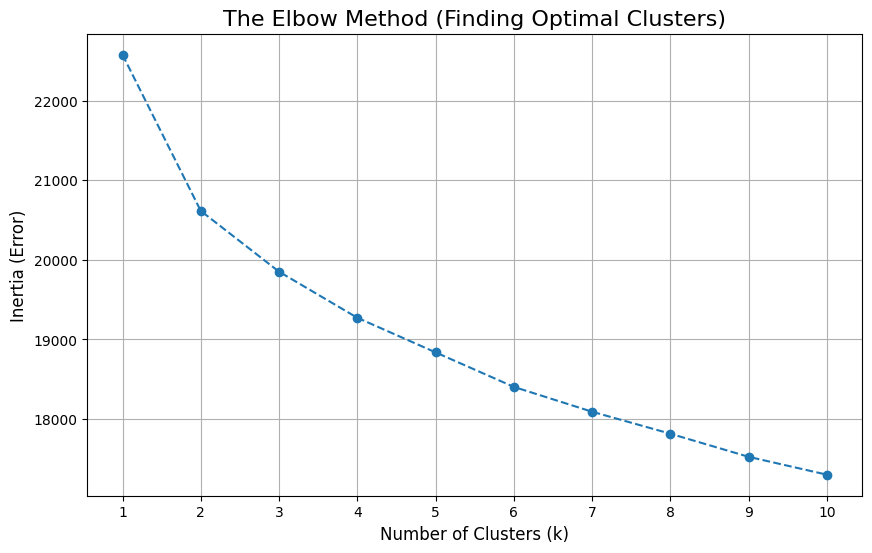

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- STEP 1: STANDARDIZATION ---
# Algorithms like K-Means need scaled data
feature_cols = [f'Q{i}' for i in range(1, 22)]
X = df[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- STEP 2: PCA (Dimensionality Reduction) ---
# Let's compress 21 dimensions down to 2 so we can visualize it later
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained Variance by 2 Components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")
# Note: Low variance here confirms the data is 'noisy', but we proceed.

# --- STEP 3: THE ELBOW METHOD ---
# We test K=1 to K=10 clusters to find the "sweet spot"
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# --- STEP 4: PLOT THE ELBOW ---
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('The Elbow Method (Finding Optimal Clusters)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Error)', fontsize=12)
plt.xticks(K_range)
plt.grid(True)
plt.show()

## Feature Engineering and Clustering Preparation

## Cluster Evaluation Metrics with Silhouette Score

The **Silhouette Score** measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1:
- **Close to 1**: The object is well matched to its cluster and far from neighboring clusters.
- **Close to 0**: The object is on or very close to the decision boundary between clusters.
- **Negative**: The object might be assigned to the wrong cluster.

We compute the Silhouette Score for different values of k to validate the choice of k=3 from the Elbow method.

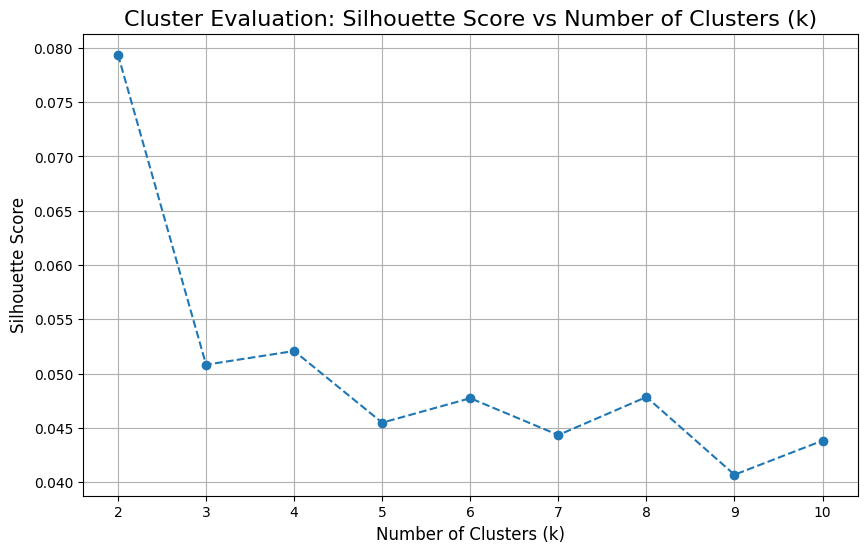


--- Cluster Evaluation (k=3) ---
Silhouette Score: 0.0508
Interpretation: Weak structure


In [50]:
from sklearn.metrics import silhouette_score

# Silhouette score requires at least 2 clusters
K_range_sil = range(2, 11)
silhouette_scores = []

for k in K_range_sil:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels_temp)
    silhouette_scores.append(score)

# Plot Silhouette Score vs k
plt.figure(figsize=(10, 6))
plt.plot(K_range_sil, silhouette_scores, marker='o', linestyle='--')
plt.title('Cluster Evaluation: Silhouette Score vs Number of Clusters (k)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(list(K_range_sil))
plt.grid(True)
plt.show()

# Report Silhouette Score for chosen k=3
k_chosen = 3
kmeans_chosen = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
labels_chosen = kmeans_chosen.fit_predict(X_scaled)
silhouette_k3 = silhouette_score(X_scaled, labels_chosen)
print(f"\n--- Cluster Evaluation (k={k_chosen}) ---")
print(f"Silhouette Score: {silhouette_k3:.4f}")
print(f"Interpretation: {'Good structure' if silhouette_k3 > 0.5 else 'Reasonable structure' if silhouette_k3 > 0.25 else 'Weak structure'}")

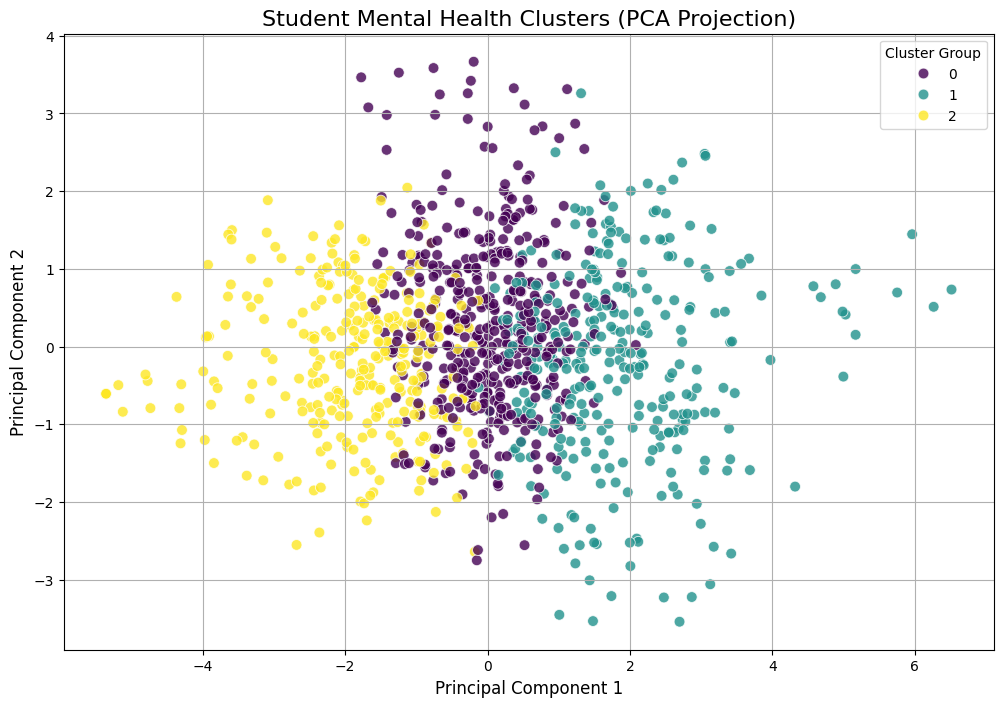


--- Cluster Profiles (Mean Scores) ---
         Depression_Score  Anxiety_Score  Stress_Score
Cluster                                               
0               17.398664      19.126949     19.077951
1               25.577287      23.678233     23.444795
2               11.462783      12.770227     11.676375

--- Cluster Sizes ---
Cluster
0    449
1    317
2    309
Name: count, dtype: int64

Cluster 0: Avg Dep=17.4, Anx=19.1, Stress=19.1

Cluster 1: Avg Dep=25.6, Anx=23.7, Stress=23.4

Cluster 2: Avg Dep=11.5, Anx=12.8, Stress=11.7


In [51]:
# --- STEP 1: APPLY K-MEANS CLUSTERING ---
# Based on the Elbow plot, k=3 is the most logical starting point
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# --- STEP 2: VISUALIZE CLUSTERS (PCA 2D Projection) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=60, alpha=0.8)
plt.title('Student Mental Health Clusters (PCA Projection)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster Group')
plt.grid(True)
plt.show()

# --- STEP 3: INTERPRET THE CLUSTERS (The "Novelty") ---
# We calculate the mean score of the original (Raw) DASS-21 scales for each cluster
# This tells us what defines each group.
cluster_profile = df.groupby('Cluster')[['Depression_Score', 'Anxiety_Score', 'Stress_Score']].mean()
cluster_counts = df['Cluster'].value_counts()

print("\n--- Cluster Profiles (Mean Scores) ---")
print(cluster_profile)
print("\n--- Cluster Sizes ---")
print(cluster_counts)

# Let's give them tentative names based on the scores
for i in range(3):
    d_score = cluster_profile.loc[i, 'Depression_Score']
    a_score = cluster_profile.loc[i, 'Anxiety_Score']
    s_score = cluster_profile.loc[i, 'Stress_Score']

    print(f"\nCluster {i}: Avg Dep={d_score:.1f}, Anx={a_score:.1f}, Stress={s_score:.1f}")

In [52]:
cluster_profile = df.groupby("Cluster")[["Depression_Score", "Anxiety_Score", "Stress_Score"]].mean()
print(cluster_profile)


         Depression_Score  Anxiety_Score  Stress_Score
Cluster                                               
0               17.398664      19.126949     19.077951
1               25.577287      23.678233     23.444795
2               11.462783      12.770227     11.676375


In [53]:
cluster_label_map = {
    0: "Depression",
    1: "Anxiety",
    2: "Stress"
}


## GMM (Gaussian Mixture Model) Clustering

GMM models the data as a mixture of several Gaussian distributions. Unlike K-Means (hard assignment), GMM uses **soft assignment** (probabilities) and can capture elliptical cluster shapes. We use the same scaled features (Q1–Q21), choose the number of components via BIC, then visualize clusters on the PCA projection and interpret profiles (Depression, Anxiety, Stress).

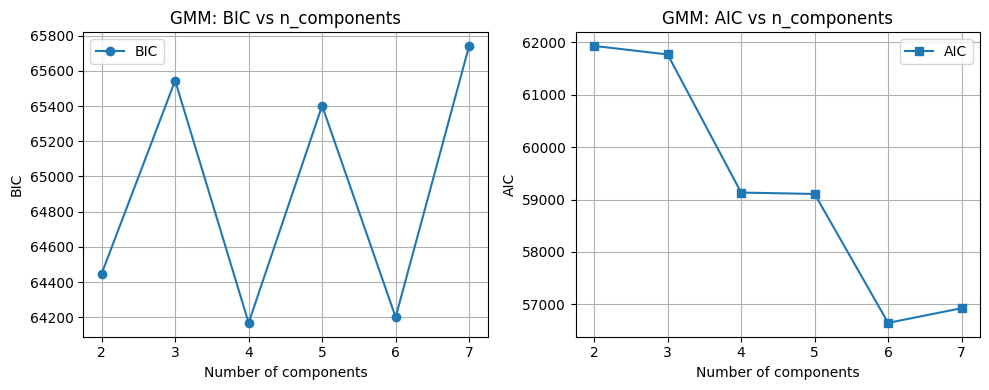

Chosen n_components (lowest BIC): 4
Silhouette Score (GMM): 0.0181


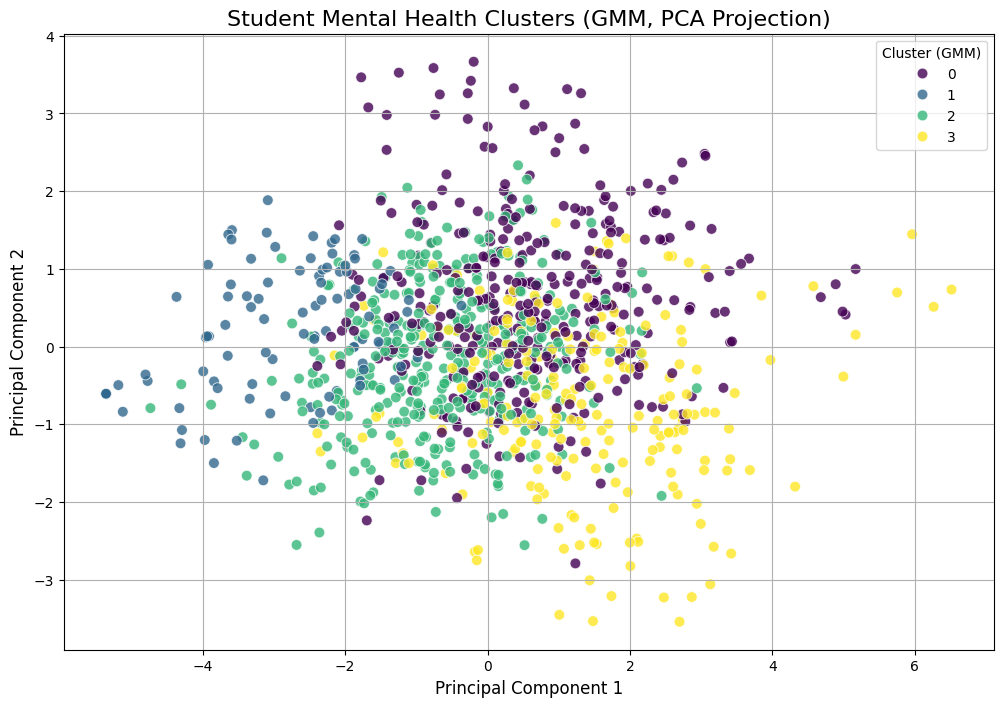


 GMM Cluster Profiles (Mean Scores) 
             Depression_Score  Anxiety_Score  Stress_Score
Cluster_GMM                                               
0                   21.593123      20.074499     19.828080
1                    7.680000      12.560000      8.340000
2                   15.348259      15.915423     17.781095
3                   22.267857      24.017857     21.000000

 GMM Cluster Sizes 
Cluster_GMM
0    349
1    100
2    402
3    224
Name: count, dtype: int64

GMM Cluster 0: Avg Dep=21.6, Anx=20.1, Stress=19.8

GMM Cluster 1: Avg Dep=7.7, Anx=12.6, Stress=8.3

GMM Cluster 2: Avg Dep=15.3, Anx=15.9, Stress=17.8

GMM Cluster 3: Avg Dep=22.3, Anx=24.0, Stress=21.0


In [54]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# --- STEP 1: CHOOSE NUMBER OF COMPONENTS (BIC) ---
bics = []
aics = []
K_range = range(2, 8)
for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, bics, 'o-', label='BIC')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('GMM: BIC vs n_components')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(K_range, aics, 's-', label='AIC')
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.title('GMM: AIC vs n_components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Use n_components with lowest BIC (or fix to 3 for comparison with K-Means)
n_components_gmm = int(K_range[np.argmin(bics)])
print(f"Chosen n_components (lowest BIC): {n_components_gmm}")

# --- STEP 2: FIT GMM AND ASSIGN CLUSTERS ---
gmm = GaussianMixture(n_components=n_components_gmm, random_state=42, covariance_type='full')
df['Cluster_GMM'] = gmm.fit_predict(X_scaled)
silhouette_gmm = silhouette_score(X_scaled, df['Cluster_GMM'])
print(f"Silhouette Score (GMM): {silhouette_gmm:.4f}")

# --- STEP 3: VISUALIZE CLUSTERS (PCA 2D) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_GMM'], palette='viridis', s=60, alpha=0.8)
plt.title('Student Mental Health Clusters (GMM, PCA Projection)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster (GMM)')
plt.grid(True)
plt.show()

# --- STEP 4: CLUSTER PROFILES (DASS-21 SCALES) ---
cluster_profile_gmm = df.groupby('Cluster_GMM')[['Depression_Score', 'Anxiety_Score', 'Stress_Score']].mean()
cluster_counts_gmm = df['Cluster_GMM'].value_counts().sort_index()

print("\n GMM Cluster Profiles (Mean Scores) ")
print(cluster_profile_gmm)
print("\n GMM Cluster Sizes ")
print(cluster_counts_gmm)

for i in range(n_components_gmm):
    d_score = cluster_profile_gmm.loc[i, 'Depression_Score']
    a_score = cluster_profile_gmm.loc[i, 'Anxiety_Score']
    s_score = cluster_profile_gmm.loc[i, 'Stress_Score']
    print(f"\nGMM Cluster {i}: Avg Dep={d_score:.1f}, Anx={a_score:.1f}, Stress={s_score:.1f}")

In [55]:
# SEVERITY DISTRIBUTION INSIDE EACH CLUSTER

print("\n===== SEVERITY DISTRIBUTION PER CLUSTER =====")

for cluster in sorted(df["Cluster"].unique()):
    print(f"\n--- Cluster {cluster} ---")
    
    print("\nDepression Levels:")
    print(df[df["Cluster"] == cluster]["Depression_Level"].value_counts(normalize=True) * 100)
    
    print("\nAnxiety Levels:")
    print(df[df["Cluster"] == cluster]["Anxiety_Level"].value_counts(normalize=True) * 100)
    
    print("\nStress Levels:")
    print(df[df["Cluster"] == cluster]["Stress_Level"].value_counts(normalize=True) * 100)



===== SEVERITY DISTRIBUTION PER CLUSTER =====

--- Cluster 0 ---

Depression Levels:
Depression_Level
Moderate            52.561247
Severe              19.821826
Mild                17.594655
Normal               6.013363
Extremely Severe     4.008909
Name: proportion, dtype: float64

Anxiety Levels:
Anxiety_Level
Extremely Severe    49.443207
Severe              28.285078
Moderate            21.158129
Mild                 0.890869
Normal               0.222717
Name: proportion, dtype: float64

Stress Levels:
Stress_Level
Moderate            38.307350
Mild                29.844098
Normal              19.821826
Severe              11.804009
Extremely Severe     0.222717
Name: proportion, dtype: float64

--- Cluster 1 ---

Depression Levels:
Depression_Level
Severe              39.116719
Extremely Severe    37.539432
Moderate            22.712934
Mild                 0.630915
Name: proportion, dtype: float64

Anxiety Levels:
Anxiety_Level
Extremely Severe    77.287066
Severe            

## DBSCAN Clustering 

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) improves over K-Means by:
- **No need to specify the number of clusters** : finds clusters based on density
- **Handles noise** : labels low-density points as noise (-1) instead of forcing them into a cluster
- **Arbitrary cluster shapes** : can find non-spherical clusters

We apply DBSCAN on the same scaled features, then compare cluster quality (e.g. Silhouette) and profiles with K-Means.


 DBSCAN PARAMETER SEARCH 


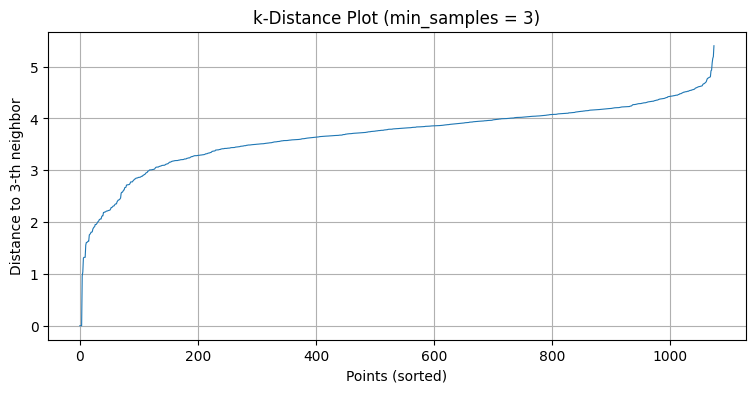

min_samples=3, eps=4.149 | clusters=4, noise=10.6% | silhouette=0.0384
min_samples=3, eps=4.208 | clusters=1, noise=8.2% | silhouette=-1.0000
min_samples=3, eps=4.325 | clusters=1, noise=4.8% | silhouette=-1.0000
min_samples=3, eps=4.492 | clusters=1, noise=2.0% | silhouette=-1.0000


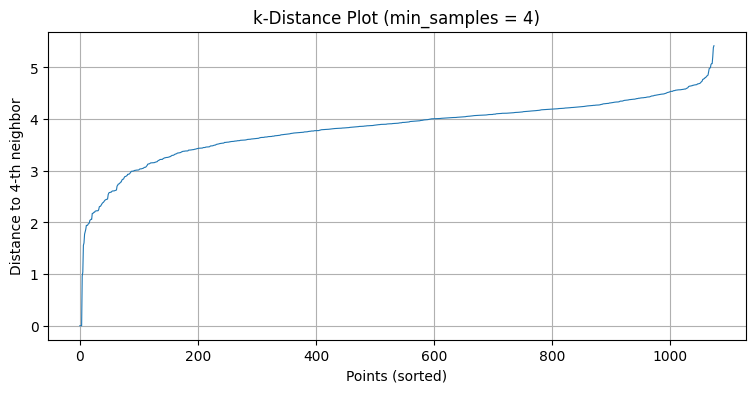

min_samples=4, eps=4.255 | clusters=3, noise=7.3% | silhouette=0.0712
min_samples=4, eps=4.336 | clusters=2, noise=5.2% | silhouette=0.1238
min_samples=4, eps=4.441 | clusters=2, noise=2.4% | silhouette=0.1177
min_samples=4, eps=4.572 | clusters=1, noise=0.9% | silhouette=-1.0000


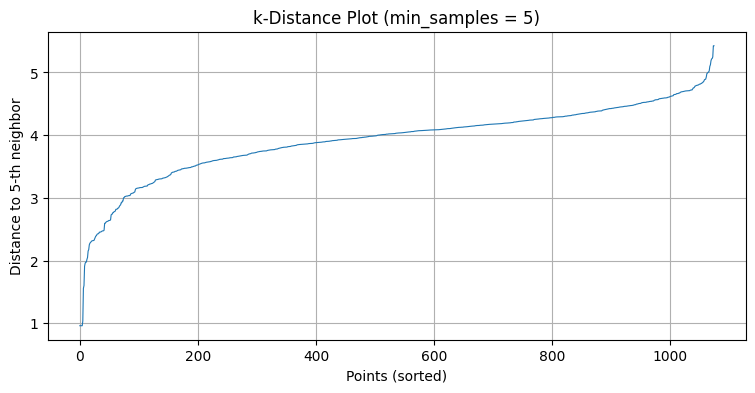

min_samples=5, eps=4.355 | clusters=1, noise=5.2% | silhouette=-1.0000
min_samples=5, eps=4.444 | clusters=1, noise=2.9% | silhouette=-1.0000
min_samples=5, eps=4.538 | clusters=1, noise=1.3% | silhouette=-1.0000
min_samples=5, eps=4.693 | clusters=1, noise=0.6% | silhouette=-1.0000


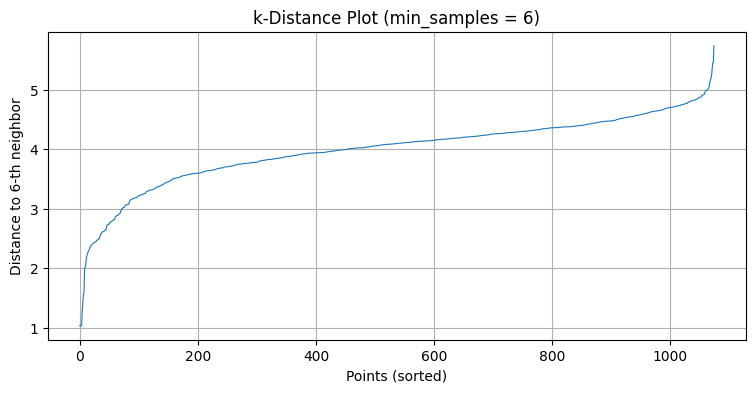

min_samples=6, eps=4.421 | clusters=1, noise=4.2% | silhouette=-1.0000
min_samples=6, eps=4.510 | clusters=1, noise=2.0% | silhouette=-1.0000
min_samples=6, eps=4.625 | clusters=1, noise=0.8% | silhouette=-1.0000
min_samples=6, eps=4.753 | clusters=1, noise=0.6% | silhouette=-1.0000

 BEST DBSCAN CONFIGURATION 
{'silhouette': 0.12381634552463652, 'eps': np.float64(4.335772453058609), 'min_samples': 4, 'labels': array([0, 0, 0, ..., 0, 0, 0], shape=(1075,))}

Final Clusters: 2
Noise Points: 56 (5.21%)
Silhouette Score: 0.1238
Davies-Bouldin Index: 0.7714
Calinski-Harabasz Index: 1.6426


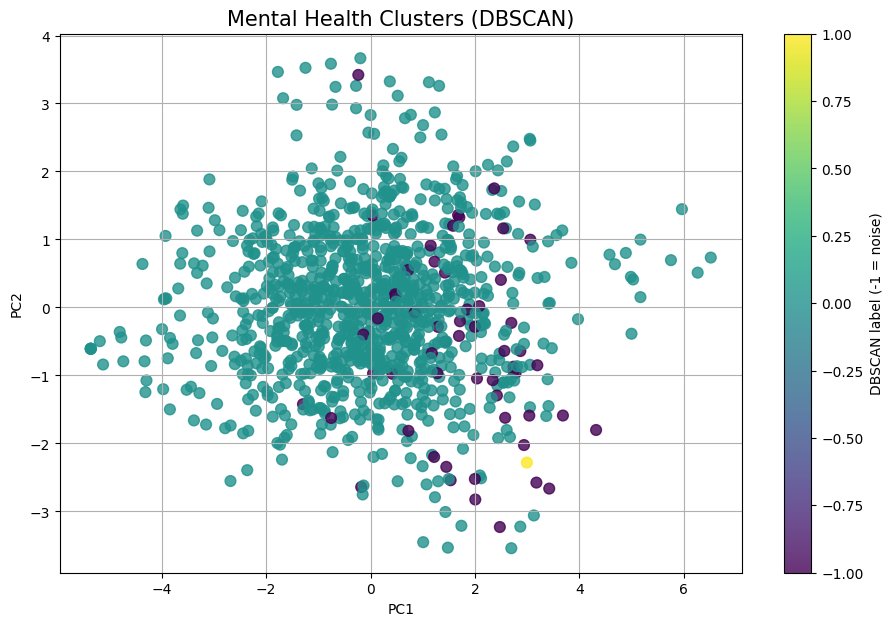


 DBSCAN Cluster Profiles (Mean DASS Scores) 
                Depression_Score  Anxiety_Score  Stress_Score
Cluster_DBSCAN                                               
0                       17.70334      18.335953     18.009823
1                       30.00000      28.000000     24.000000

 DBSCAN Cluster Sizes 
Cluster_DBSCAN
0    1018
1       1
Name: count, dtype: int64


In [56]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# STEP 1: k-distance plot (eps estimation)

min_samples_list = [3, 4, 5, 6]  # try multiple values
best_result = {"silhouette": -1, "eps": None, "min_samples": None, "labels": None}

print("\n DBSCAN PARAMETER SEARCH ")

for min_samples in min_samples_list:
    
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)
    distances = np.sort(distances[:, -1])
    
    # Plot k-distance curve
    plt.figure(figsize=(9, 4))
    plt.plot(distances, linewidth=0.8)
    plt.title(f'k-Distance Plot (min_samples = {min_samples})')
    plt.xlabel('Points (sorted)')
    plt.ylabel(f'Distance to {min_samples}-th neighbor')
    plt.grid(True)
    plt.show()
    
    # Try multiple eps values (percentiles)
    eps_candidates = np.percentile(distances, [80, 85, 90, 95])
    
    for eps in eps_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        labels = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters >= 2:
            mask = labels >= 0
            sil = silhouette_score(X_scaled[mask], labels[mask])
            dbi = davies_bouldin_score(X_scaled[mask], labels[mask])
            chi = calinski_harabasz_score(X_scaled[mask], labels[mask])
        else:
            sil, dbi, chi = -1, np.inf, 0
        
        print(f"min_samples={min_samples}, eps={eps:.3f} | clusters={n_clusters}, noise={100*n_noise/len(labels):.1f}% | silhouette={sil:.4f}")

        # Select best model (maximize silhouette, minimize noise)
        if sil > best_result["silhouette"] and n_clusters >= 2 and n_noise/len(labels) < 0.5:
            best_result.update({
                "silhouette": sil,
                "eps": eps,
                "min_samples": min_samples,
                "labels": labels
            })

print("\n BEST DBSCAN CONFIGURATION ")
print(best_result)

labels_dbscan = best_result["labels"]

# STEP 2: Final DBSCAN Evaluation

n_clusters_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_db = np.sum(labels_dbscan == -1)

print(f"\nFinal Clusters: {n_clusters_db}")
print(f"Noise Points: {n_noise_db} ({100*n_noise_db/len(labels_dbscan):.2f}%)")

mask = labels_dbscan >= 0
sil_db = silhouette_score(X_scaled[mask], labels_dbscan[mask])
dbi_db = davies_bouldin_score(X_scaled[mask], labels_dbscan[mask])
chi_db = calinski_harabasz_score(X_scaled[mask], labels_dbscan[mask])

print(f"Silhouette Score: {sil_db:.4f}")
print(f"Davies-Bouldin Index: {dbi_db:.4f}")
print(f"Calinski-Harabasz Index: {chi_db:.4f}")

# Store labels
df['Cluster_DBSCAN'] = labels_dbscan

# STEP 3: Visualization (PCA)

plt.figure(figsize=(11, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='viridis', s=60, alpha=0.8)
plt.colorbar(scatter, label='DBSCAN label (-1 = noise)')
plt.title('Mental Health Clusters (DBSCAN)', fontsize=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# STEP 4: Cluster Profile Analysis

df_valid = df[df['Cluster_DBSCAN'] >= 0]

cluster_profile_db = df_valid.groupby('Cluster_DBSCAN')[['Depression_Score', 'Anxiety_Score', 'Stress_Score']].mean()
cluster_counts_db = df_valid['Cluster_DBSCAN'].value_counts().sort_index()

print("\n DBSCAN Cluster Profiles (Mean DASS Scores) ")
print(cluster_profile_db)

print("\n DBSCAN Cluster Sizes ")
print(cluster_counts_db)


In [57]:
# If DBSCAN noise is coded as -1, drop noise first
mask = df['Cluster_DBSCAN'] != -1
labels_db = df.loc[mask, 'Cluster_DBSCAN']
labels_gmm = df.loc[mask, 'Cluster_GMM']

# Cross-tab: how DBSCAN clusters map to GMM clusters
ct = pd.crosstab(labels_db, labels_gmm)
print(ct)

Cluster_GMM       0    1    2    3
Cluster_DBSCAN                    
0               335  100  397  186
1                 0    0    0    1


In [58]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_db, labels_gmm)
nmi = normalized_mutual_info_score(labels_db, labels_gmm)

print(f"Adjusted Rand Index (DBSCAN vs GMM): {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

Adjusted Rand Index (DBSCAN vs GMM): 0.001
Normalized Mutual Information: 0.003


--- Model Performance (Predicting Clusters) ---
              precision    recall  f1-score   support

           0       0.78      0.86      0.81        90
           1       0.83      0.83      0.83        63
           2       0.89      0.76      0.82        62

    accuracy                           0.82       215
   macro avg       0.83      0.81      0.82       215
weighted avg       0.82      0.82      0.82       215


--- Confusion Matrix ---
[[77  8  5]
 [10 52  1]
 [12  3 47]]


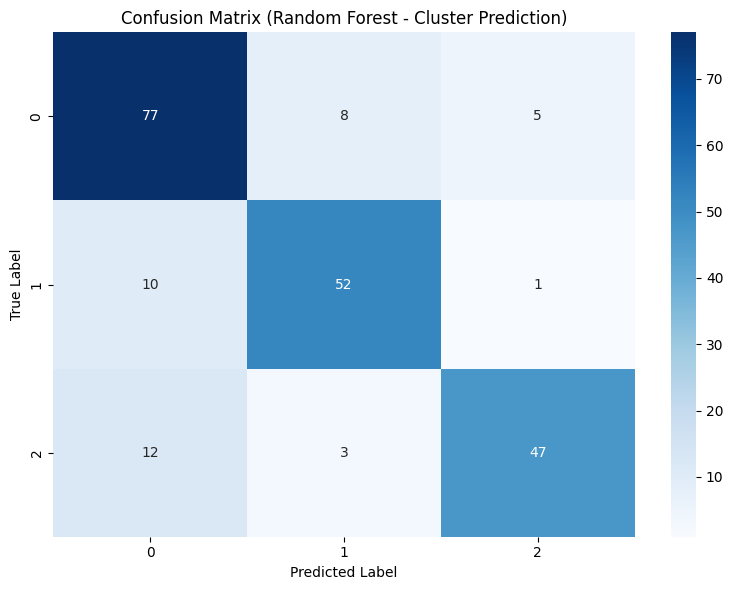


--- TOP 5 SYMPTOMS DRIVING THE CLUSTERS ---


,Question,Importance,Description
2,Q3,0.136011,No positive feelings
10,Q11,0.083465,Agitation
20,Q21,0.075610,Life meaningless
17,Q18,0.052409,Touchiness
11,Q12,0.048326,Diff. relaxing
19,Q20,0.047815,Unreasonable fear
15,Q16,0.046295,Lack of enthusiasm
12,Q13,0.045359,Down-hearted
4,Q5,0.043777,Lack of initiative
1,Q2,0.041273,Dryness of mouth


C:\Users\User\AppData\Local\Temp\ipykernel_5484\3398645016.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Description', data=imp_df.head(10), palette='magma')


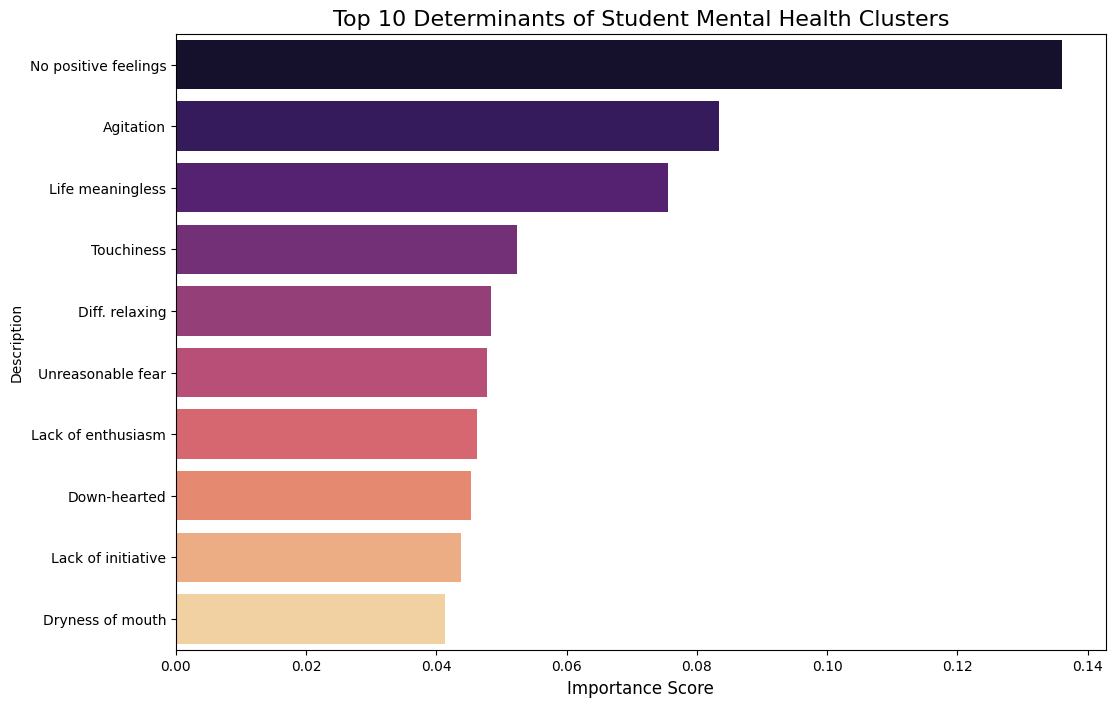

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- STEP 1: PREPARE DATA FOR SUPERVISED LEARNING ---
# Target = The Cluster we just discovered
y = df['Cluster']
# Features = The individual questions (Q1-Q21)
X = df[[f'Q{i}' for i in range(1, 22)]]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- STEP 2: TRAIN RANDOM FOREST ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- STEP 3: EVALUATE PERFORMANCE ---
# We need to verify the model actually learned the difference
y_pred = rf.predict(X_test)
print("--- Model Performance (Predicting Clusters) ---")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\n--- Confusion Matrix ---")
print(cm)
# Visualize confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix (Random Forest - Cluster Prediction)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- STEP 4: EXTRACT FEATURE IMPORTANCE ---
# This is the "Key Finding" of your paper
importances = rf.feature_importances_
feature_names = [f'Q{i}' for i in range(1, 22)]

# Create a DataFrame to sort and visualize
imp_df = pd.DataFrame({'Question': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# Map the Question Numbers back to the Text (from your first message) for readability
q_map = {
    'Q1': 'Hard to wind down', 'Q2': 'Dryness of mouth', 'Q3': 'No positive feelings',
    'Q4': 'Breathing difficulty', 'Q5': 'Lack of initiative', 'Q6': 'Over-reacting',
    'Q7': 'Trembling', 'Q8': 'Nervous energy', 'Q9': 'Fear of panic',
    'Q10': 'Nothing to look forward', 'Q11': 'Agitation', 'Q12': 'Diff. relaxing',
    'Q13': 'Down-hearted', 'Q14': 'Intolerance to interrupt', 'Q15': 'Close to panic',
    'Q16': 'Lack of enthusiasm', 'Q17': 'Low self-worth', 'Q18': 'Touchiness',
    'Q19': 'Heart awareness', 'Q20': 'Unreasonable fear', 'Q21': 'Life meaningless'
}
imp_df['Description'] = imp_df['Question'].map(q_map)

print("\n--- TOP 5 SYMPTOMS DRIVING THE CLUSTERS ---")
display(imp_df.head(10))

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Description', data=imp_df.head(10), palette='magma')
plt.title('Top 10 Determinants of Student Mental Health Clusters', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.show()

In [60]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score

# --- STRATIFIED K-FOLD EVALUATION (Random Forest on Cluster labels) ---
# We reuse X, y defined in the previous cell

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
cv_results = cross_validate(
    rf_cv,
    X,
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
)

print(" Stratified 5-Fold CV (Random Forest, predicting Cluster) ")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric:>16}: {scores.mean():.3f} +/- {scores.std():.3f}")

 Stratified 5-Fold CV (Random Forest, predicting Cluster) 
        accuracy: 0.848 +/- 0.017
        f1_macro: 0.848 +/- 0.017
 precision_macro: 0.868 +/- 0.014
    recall_macro: 0.838 +/- 0.018


In [61]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def report_per_class_metrics(model_name, y_true, y_pred, labels=None):
    print(f"\n=== {model_name}: per‑class metrics ===")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("\nConfusion matrix:\n", cm)

    if labels is None:
        labels = sorted(pd.unique(list(y_true) + list(y_pred)))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix – {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

## Support Vector Machine (SVM)

--- SVM Model Performance (Predicting Clusters) ---
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        90
           1       0.92      0.94      0.93        63
           2       0.93      0.89      0.91        62

    accuracy                           0.92       215
   macro avg       0.92      0.92      0.92       215
weighted avg       0.92      0.92      0.92       215


--- Confusion Matrix (SVM) ---
[[84  2  4]
 [ 4 59  0]
 [ 4  3 55]]


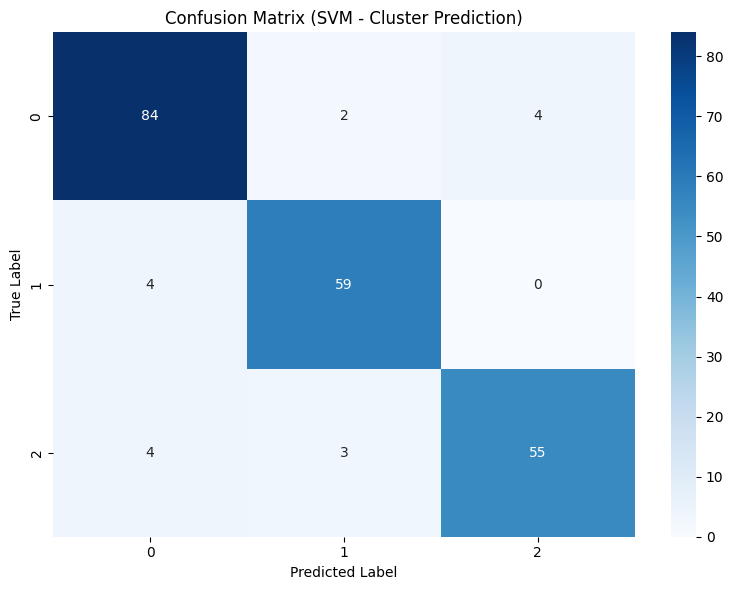


SVM Test Accuracy: 0.9209
SVM Test F1 Score (weighted): 0.9208
SVM Test Recall (weighted): 0.9209


In [62]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# --- STEP 1: USE SAME FEATURES AND TARGET AS RANDOM FOREST ---
# Target = Cluster labels from K-Means
y_svm = df['Cluster']
# Features = Q1-Q21
X_svm = df[[f'Q{i}' for i in range(1, 22)]]

# Split (same split strategy for fair comparison)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.2, random_state=42, stratify=y_svm
)

# --- STEP 2: SCALE FEATURES (SVM is sensitive to feature scales) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

# --- STEP 3: TRAIN SVM CLASSIFIER ---
# Using RBF kernel (default); C=1.0, gamma='scale' for stability
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train_svm)

# --- STEP 4: EVALUATE ---
y_pred_svm = svm_model.predict(X_test_scaled)
print("--- SVM Model Performance (Predicting Clusters) ---")
print(classification_report(y_test_svm, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
print("\n--- Confusion Matrix (SVM) ---")
print(cm_svm)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test_svm.unique()),
            yticklabels=sorted(y_test_svm.unique()))
plt.title('Confusion Matrix (SVM - Cluster Prediction)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Accuracy, F1 score, Recall
from sklearn.metrics import accuracy_score, f1_score, recall_score
svm_accuracy = accuracy_score(y_test_svm, y_pred_svm)
svm_f1 = f1_score(y_test_svm, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test_svm, y_pred_svm, average='weighted')
print(f"\nSVM Test Accuracy: {svm_accuracy:.4f}")
print(f"SVM Test F1 Score (weighted): {svm_f1:.4f}")
print(f"SVM Test Recall (weighted): {svm_recall:.4f}")

In [63]:
def get_final_label(row):
    cluster = row["Predicted_Cluster"]   # SVM predicted cluster
    
    label = cluster_label_map[cluster]
    
    if label == "Depression":
        severity = row["Depression_Level"]
    elif label == "Anxiety":
        severity = row["Anxiety_Level"]
    else:
        severity = row["Stress_Level"]
    
    return f"{label} ({severity})"

# SVM predicted cluster store 
df["Predicted_Cluster"] = svm_model.predict(X_scaled)

# Final output generate 
df["Final_Output"] = df.apply(get_final_label, axis=1)

df[["Predicted_Cluster", "Final_Output"]].head()


,Predicted_Cluster,Final_Output
0,1,Anxiety (Severe)
1,2,Stress (Normal)
2,1,Anxiety (Extremely Severe)
3,1,Anxiety (Extremely Severe)
4,2,Stress (Normal)


In [64]:
# CONFIDENCE SCORE FROM SVM

svm_model_proba = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_model_proba.fit(X_train, y_train)

proba = svm_model_proba.predict_proba(X_scaled)
confidence_scores = proba.max(axis=1)

df["Confidence_Score"] = confidence_scores


c:\Users\User\Downloads\DASS21-main\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [65]:
risk_map = {
    "Normal": "Low Risk",
    "Mild": "Low Risk",
    "Moderate": "Medium Risk",
    "Severe": "High Risk",
    "Extremely Severe": "Critical Risk"
}

df["Depression_Risk"] = df["Depression_Level"].map(risk_map)
df["Anxiety_Risk"] = df["Anxiety_Level"].map(risk_map)
df["Stress_Risk"] = df["Stress_Level"].map(risk_map)


In [66]:
def generate_summary(row):
    cluster = row["Predicted_Cluster"]
    label = cluster_label_map[cluster]
    
    if label == "Depression":
        severity = row["Depression_Level"]
        risk = row["Depression_Risk"]
    elif label == "Anxiety":
        severity = row["Anxiety_Level"]
        risk = row["Anxiety_Risk"]
    else:
        severity = row["Stress_Level"]
        risk = row["Stress_Risk"]
    
    return f"The individual shows {severity.lower()} level of {label.lower()} symptoms, indicating {risk.lower()}."

df["Profile_Summary"] = df.apply(generate_summary, axis=1)


In [67]:
def final_output(row):
    cluster = row["Predicted_Cluster"]
    label = cluster_label_map[cluster]
    
    if label == "Depression":
        severity = row["Depression_Level"]
        risk = row["Depression_Risk"]
    elif label == "Anxiety":
        severity = row["Anxiety_Level"]
        risk = row["Anxiety_Risk"]
    else:
        severity = row["Stress_Level"]
        risk = row["Stress_Risk"]
    
    confidence = row["Confidence_Score"]
    
    return f"{label} | Severity: {severity} | Risk: {risk} | Confidence: {confidence:.2f}"

df["Final_Output"] = df.apply(final_output, axis=1)

df[["Final_Output"]].head()


,Final_Output
0,Anxiety | Severity: Severe | Risk: High Risk |...
1,Stress | Severity: Normal | Risk: Low Risk | C...
2,Anxiety | Severity: Extremely Severe | Risk: C...
3,Anxiety | Severity: Extremely Severe | Risk: C...
4,Stress | Severity: Normal | Risk: Low Risk | C...


Running XGBoost hyperparameter search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\User\Downloads\DASS21-main\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [17:45:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found:
{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV accuracy: 0.9035


c:\Users\User\Downloads\DASS21-main\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [17:45:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Model Performance (Predicting Clusters) ---
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        90
           1       0.89      0.90      0.90        63
           2       0.95      0.84      0.89        62

    accuracy                           0.89       215
   macro avg       0.90      0.88      0.89       215
weighted avg       0.89      0.89      0.89       215


XGBoost Test Accuracy: 0.8884
XGBoost Test F1 Score (weighted): 0.8885
XGBoost Test Recall (weighted): 0.8884


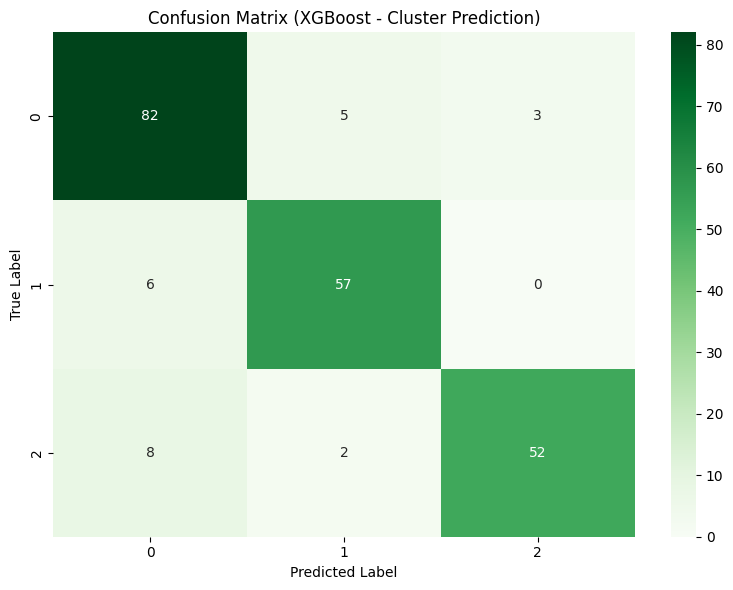

In [68]:
# If not installed yet, run once in a separate cell:
# !pip install xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix

# --- FEATURES & TARGET (same as SVM) ---
y_xgb = df['Cluster']
X_xgb = df[[f'Q{i}' for i in range(1, 22)]]

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb
)

# (Optional) scaling is not required for tree-based models, so we use raw values

# --- HYPERPARAMETER SEARCH FOR BEST ACCURACY ---
xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    tree_method='hist',        # faster, good default
    random_state=42,
    use_label_encoder=False
)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.5, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=40,              # increase for a more exhaustive search if you have time
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Running XGBoost hyperparameter search...")
xgb_search.fit(X_train_xgb, y_train_xgb)

print("\nBest parameters found:")
print(xgb_search.best_params_)
print(f"Best CV accuracy: {xgb_search.best_score_:.4f}")

# --- TRAIN BEST MODEL ON FULL TRAINING DATA ---
best_xgb = xgb_search.best_estimator_
best_xgb.fit(X_train_xgb, y_train_xgb)

# --- EVALUATE ON TEST SET ---
y_pred_xgb = best_xgb.predict(X_test_xgb)

print("\n--- XGBoost Model Performance (Predicting Clusters) ---")
print(classification_report(y_test_xgb, y_pred_xgb))

xgb_accuracy = accuracy_score(y_test_xgb, y_pred_xgb)
xgb_f1 = f1_score(y_test_xgb, y_pred_xgb, average='weighted')
xgb_recall = recall_score(y_test_xgb, y_pred_xgb, average='weighted')

print(f"\nXGBoost Test Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost Test F1 Score (weighted): {xgb_f1:.4f}")
print(f"XGBoost Test Recall (weighted): {xgb_recall:.4f}")

# Confusion matrix
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(y_test_xgb.unique()),
            yticklabels=sorted(y_test_xgb.unique()))
plt.title('Confusion Matrix (XGBoost - Cluster Prediction)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [69]:
from scipy.stats import chi2_contingency

# --- STEP 1: GENDER DISTRIBUTION PER CLUSTER ---
# Create a contingency table (Cluster vs Gender)
gender_crosstab = pd.crosstab(df['Cluster'], df['Gender'])

print("\n--- Gender Distribution by Cluster (Raw Counts) ---")
display(gender_crosstab)

print("\n--- Gender Distribution by Cluster (Percentages) ---")
# Show percentages across the row (Cluster)
display(gender_crosstab.div(gender_crosstab.sum(1), axis=0) * 100)

# --- STEP 2: STATISTICAL SIGNIFICANCE (Chi-Square Test) ---
# Null Hypothesis: Gender and Mental Health Cluster are NOT related.
# Alternate Hypothesis: There IS a significant relationship.
chi2, p, dof, expected = chi2_contingency(gender_crosstab)

print("\n--- Chi-Square Test Results ---")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4e}")

if p < 0.05:
    print(" RESULT: Statistically Significant! Gender influences which cluster a student falls into.")
else:
    print(" RESULT: Not Significant. Gender does not appear to drive these clusters.")

# --- STEP 3: AGE ANALYSIS ---
# Quick check if Age varies by cluster
print("\n--- Average Age by Cluster ---")
print(df.groupby('Cluster')['Age'].describe()[['count', 'mean', 'std']])


--- Gender Distribution by Cluster (Raw Counts) ---


Gender,Female,Male
Cluster,,
0,243,206
1,118,199
2,141,168



--- Gender Distribution by Cluster (Percentages) ---


C:\Users\User\AppData\Local\Temp\ipykernel_5484\1559094403.py:12: Pandas4Warning: Starting with pandas version 4.0 all arguments of sum will be keyword-only.
  display(gender_crosstab.div(gender_crosstab.sum(1), axis=0) * 100)


Gender,Female,Male
Cluster,,
0,54.120267,45.879733
1,37.223975,62.776025
2,45.631068,54.368932



--- Chi-Square Test Results ---
Chi-Square Statistic: 21.5099
P-Value: 2.1339e-05
 RESULT: Statistically Significant! Gender influences which cluster a student falls into.

--- Average Age by Cluster ---
         count       mean       std
Cluster                            
0        449.0  22.278396  2.156904
1        317.0  22.984227  3.469086
2        309.0  22.983819  3.487882


## CatBoost

Train size: (860, 21)
Test size: (215, 21)

 CATBOOST PERFORMANCE 
Accuracy: 0.8744
Weighted F1-score: 0.8747

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86        90
           1       0.85      0.89      0.87        63
           2       0.93      0.87      0.90        62

    accuracy                           0.87       215
   macro avg       0.88      0.88      0.88       215
weighted avg       0.88      0.87      0.87       215



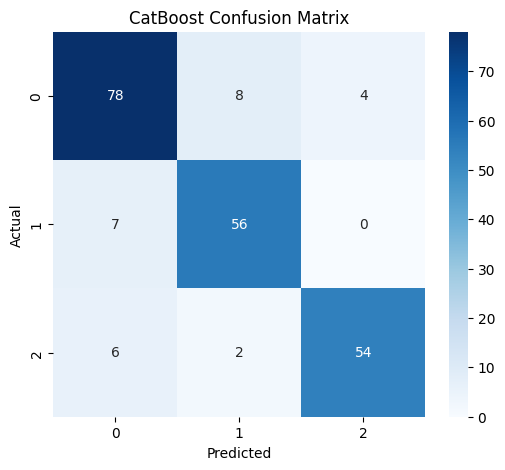

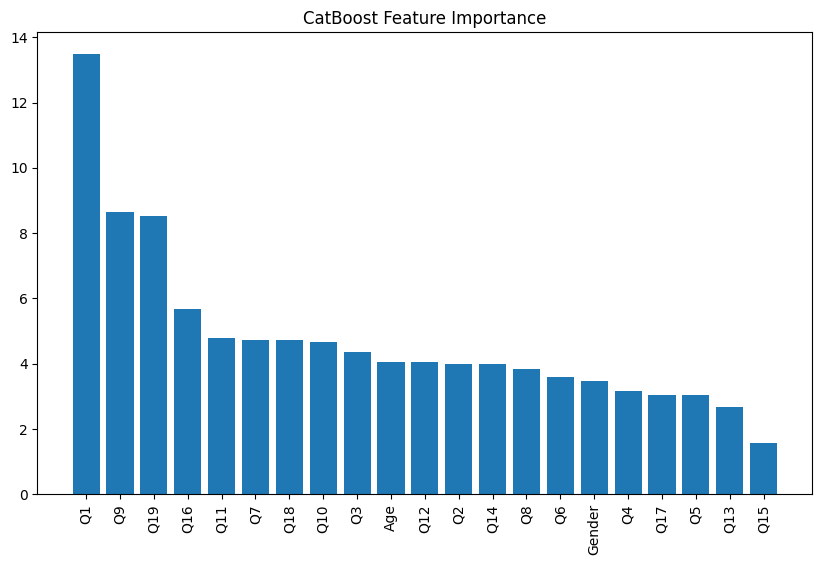

In [70]:

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TARGET VARIABLE (choose one)

y = df['Cluster']

# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# BASE CATBOOST MODEL

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train)

# PREDICTION & EVALUATION
y_pred = cat_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n CATBOOST PERFORMANCE ")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# FEATURE IMPORTANCE
importances = cat_model.get_feature_importance()
feature_names = df.drop(columns=['Cluster', 'Cluster_GMM', 'Cluster_DBSCAN'], errors='ignore').columns

plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title("CatBoost Feature Importance")
plt.show()


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pandas as pd

# Target variable (cluster labels)
y = df['Cluster']   # or df['Cluster_GMM']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

results = []

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append((name, acc, f1))
    print(f"{name} - Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

# 1) SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
evaluate_model("SVM", svm_model)

# 2) Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
evaluate_model("Random Forest", rf_model)

# 3) XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
evaluate_model("XGBoost", xgb_model)

# 4) CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0
)
evaluate_model("CatBoost", cat_model)

# Final comparison table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-score"])
print("\n===== MODEL COMPARISON TABLE =====")
print(results_df.sort_values(by="Accuracy", ascending=False))


SVM - Accuracy: 0.9116, F1-score: 0.9116
Random Forest - Accuracy: 0.8419, F1-score: 0.8424
XGBoost - Accuracy: 0.8744, F1-score: 0.8747
CatBoost - Accuracy: 0.8744, F1-score: 0.8747

===== MODEL COMPARISON TABLE =====
           Model  Accuracy  F1-score
0            SVM  0.911628  0.911642
2        XGBoost  0.874419  0.874737
3       CatBoost  0.874419  0.874729
1  Random Forest  0.841860  0.842385


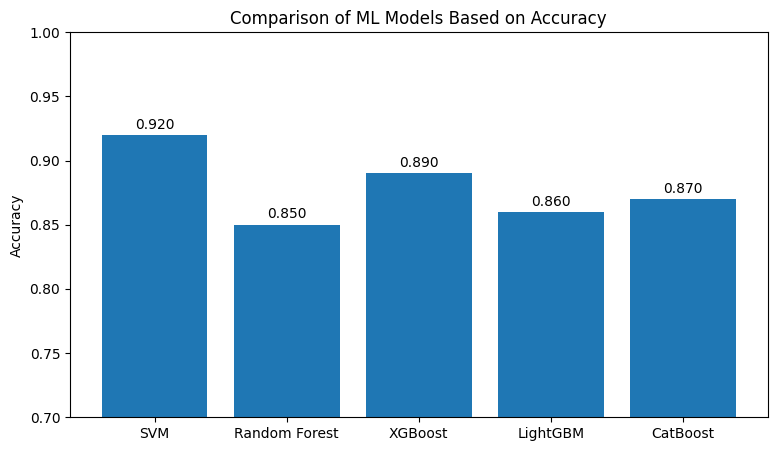

In [72]:
import matplotlib.pyplot as plt
import numpy as np

models = ['SVM', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
accuracy = [0.92, 0.85, 0.89, 0.86, 0.87]  # replace with your real values

plt.figure(figsize=(9, 5))
bars = plt.bar(models, accuracy)

plt.ylabel("Accuracy")
plt.title("Comparison of ML Models Based on Accuracy")
plt.ylim(0.7, 1.0)

# show values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}", ha='center', fontsize=10)

plt.show()


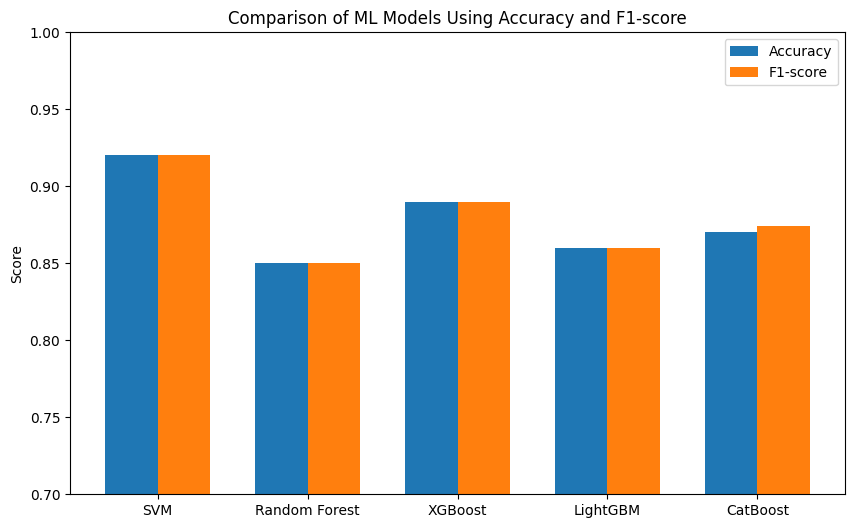

In [73]:

models = ['SVM', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
accuracy = [0.92, 0.85, 0.89, 0.86, 0.87]
f1_score = [0.92, 0.85, 0.89, 0.86, 0.874]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, f1_score, width, label='F1-score')

plt.ylabel('Score')
plt.title('Comparison of ML Models Using Accuracy and F1-score')
plt.xticks(x, models)
plt.ylim(0.7, 1.0)
plt.legend()

plt.show()


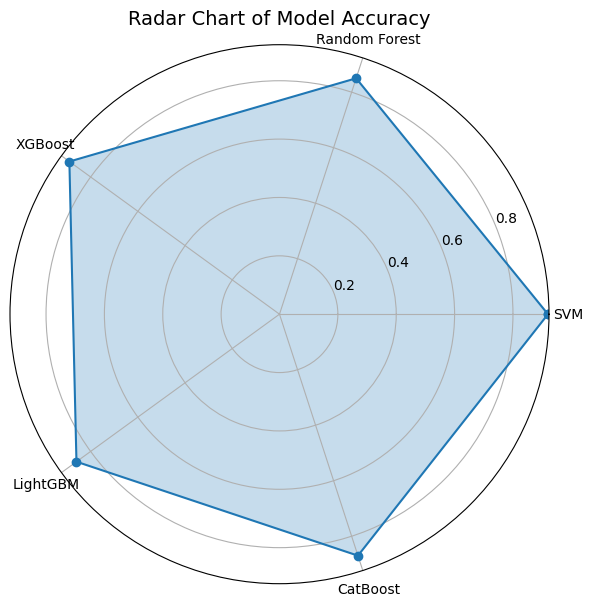

In [74]:


models = ['SVM', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
accuracy = [0.92, 0.85, 0.89, 0.86, 0.87]

angles = np.linspace(0, 2*np.pi, len(models), endpoint=False)
accuracy_cycle = accuracy + [accuracy[0]]
angles_cycle = np.concatenate([angles, [angles[0]]])

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

ax.plot(angles_cycle, accuracy_cycle, marker='o')
ax.fill(angles_cycle, accuracy_cycle, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(models)
ax.set_title("Radar Chart of Model Accuracy", fontsize=14)

plt.show()


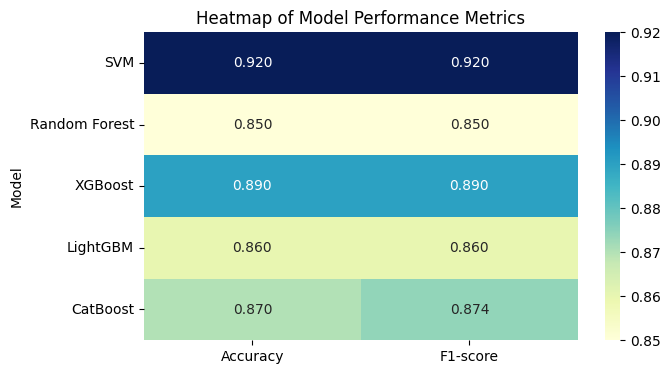

In [75]:

data = {
    "Model": ['SVM', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    "Accuracy": [0.92, 0.85, 0.89, 0.86, 0.87],
    "F1-score": [0.92, 0.85, 0.89, 0.86, 0.874]
}

df_results = pd.DataFrame(data)
df_heatmap = df_results.set_index("Model")

plt.figure(figsize=(7, 4))
sns.heatmap(df_heatmap, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Heatmap of Model Performance Metrics")
plt.show()


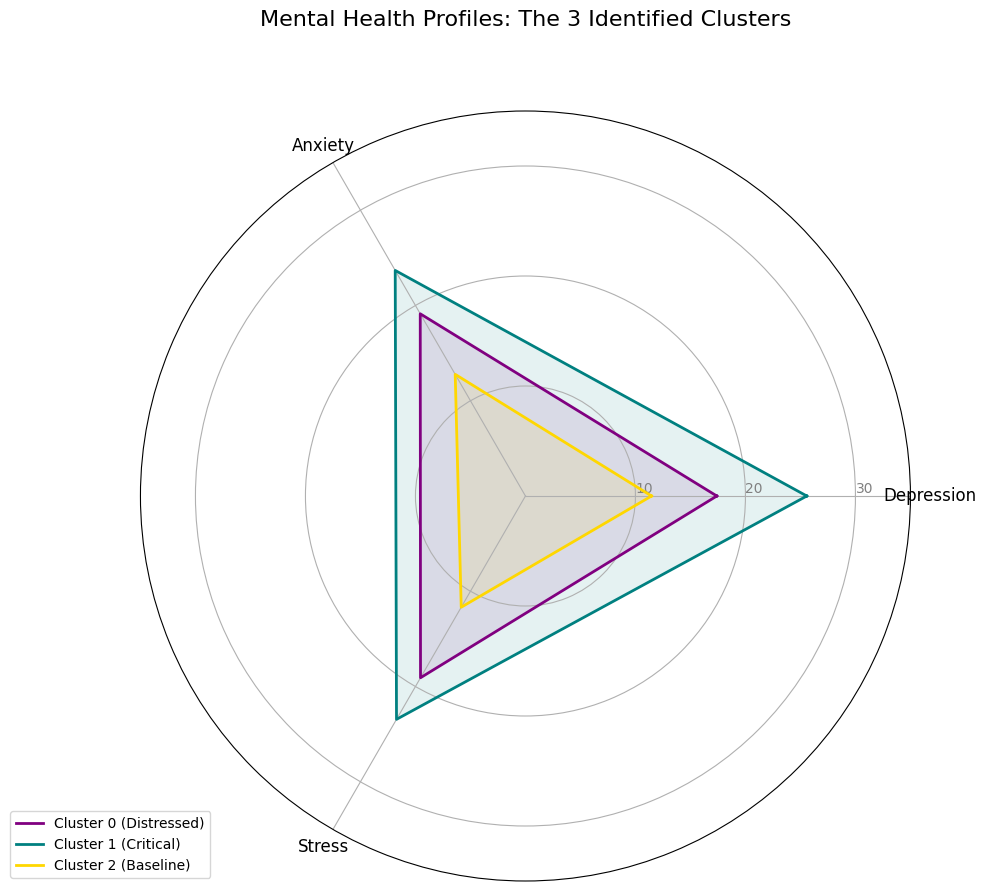

In [76]:

# --- STEP 1: PREPARE DATA ---
# We use the mean scores of the 3 sub-scales for each cluster
cluster_means = df.groupby('Cluster')[['Depression_Score', 'Anxiety_Score', 'Stress_Score']].mean()

# Normalization (Min-Max Scaling) so they fit nicely on the chart (0 to 1 scale)
# This highlights the *relative* shape of the distress
# Note: You can also plot raw scores, but normalized looks cleaner for "profiles"
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

# Let's plot the RAW scores to be scientifically accurate for the paper
categories = ['Depression', 'Anxiety', 'Stress']
N = len(categories)

# --- STEP 2: BUILD THE RADAR CHART ---
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# What are the angles for each axis?
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Close the loop

# Draw one line per cluster
colors = ['purple', 'teal', 'gold']
labels = ['Cluster 0 (Distressed)', 'Cluster 1 (Critical)', 'Cluster 2 (Baseline)']

for i in range(3):
    # Get the data for this cluster
    values = cluster_means.iloc[i].values.flatten().tolist()
    values += values[:1] # Close the loop

    # Plot
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# --- STEP 3: FORMATTING ---
plt.xticks(angles[:-1], categories, size=12)
ax.set_rlabel_position(0)
plt.yticks([10, 20, 30], ["10", "20", "30"], color="grey", size=10)
plt.ylim(0, 35) # DASS scores usually max out around 42

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Mental Health Profiles: The 3 Identified Clusters', size=16, y=1.1)

plt.show()